# Submission 03  for San Francisco Crime Classification
Yang Yang Qian<br>
Linda Dong<br>
Arthur Silveira Lima

In this notebook we will work on the problem proposed by Kaggle named: San Francisco Crime Classification<br>
You can find more info here: https://www.kaggle.com/c/sf-crime/overview/description
<br><br>
The objective of this notebook is to classify a crime using the covariantes that is presented by the data set.
In order to assess the performance we will use logloss.
<br>
The team has developed a pipeline to test different possibilities and is using GridSearch to find the optimal parameters. Multiple ML algorithms have been used, among those we have: KNN, Multivariable, Logistics, Random Forest, X-boosted Three, among others.

In [63]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict


%reload_ext autoreload
%autoreload 2
# from src.features.build_features import DataFrameSelector, SFCCTransformer, print_summary, prep_submissions

import inspect

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
import datetime

In [39]:
%run ../src/features/build_features.py

# Load Data

In [68]:
train_pd = pd.read_csv("../data/raw/train.csv")
test_pd = pd.read_csv("../data/raw/test.csv")
sample_submissions = pd.read_csv("../data/raw/sampleSubmission.csv")

# EDA

We have about 800k records in both train and test data sets. The train data set has the Category, Descript, and Resolution columns, which are missing from the test data set.

We will need to use the test data set to generate the submission to Kaggle.

TODO add more plots and EDA from scratch EDA

In [4]:
print(train_pd.shape)
print(test_pd.shape)

(878049, 9)
(884262, 7)


In [5]:
train_pd.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414


In [6]:
test_pd.head(3)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212


**Checking for NAs in the base**
* in both test and train data set 
* remove the row if there's a NA

In [7]:
print('The test_pd original shape is: '+ str(test_pd.shape))
test_pd = test_pd.dropna()
print('The test_pd NEW shape is: '+ str(test_pd.shape))

print('The train_pd original shape is: '+ str(train_pd.shape))
train_pd = train_pd.dropna()
print('The train_pd NEW shape is: '+ str(train_pd.shape))

The test_pd original shape is: (884262, 7)
The test_pd NEW shape is: (884262, 7)
The train_pd original shape is: (878049, 9)
The train_pd NEW shape is: (878049, 9)


**Category**
* categorical variable with 39 levels
* is what we are trying to predict
* largest Category of crimes is theft, at around 20% of all crime

In [8]:
print('The total number of categories is: ' + str(len(train_pd.Category.unique())))

The total number of categories is: 39


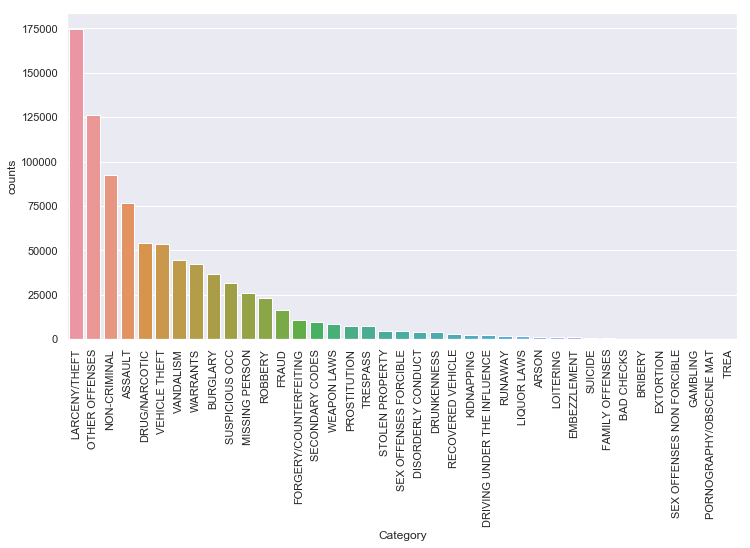

In [9]:
dat = train_pd.groupby(["Category"]).size().reset_index(name='counts').sort_values(by = "counts", ascending = False)

sns.set(rc = {"figure.figsize" : (12, 6)})
ax = sns.barplot(x = "Category", y = "counts", data=dat). \
    set_xticklabels(dat['Category'],rotation = 90)

**PdDistrict**
* categorical variable with 10 levels
* should be roughly correlated with X and Y ?
* southern district appears to have the highest number of reported crimes. Maybe larger district? more cops? or just more crime?

In [10]:
print('The total number of PdDistricts is: ' + str(len(train_pd.PdDistrict.unique())))

The total number of PdDistricts is: 10


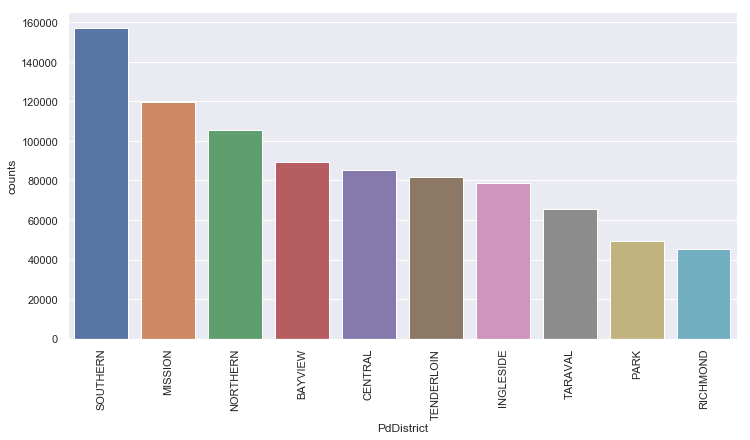

In [11]:
dat = train_pd.groupby(["PdDistrict"]).size().reset_index(name='counts').sort_values(by = "counts", ascending = False)

sns.set(rc = {"figure.figsize" : (12, 6)})
ax = sns.barplot(x="PdDistrict", y="counts", data=dat). \
    set_xticklabels(dat['PdDistrict'], rotation = 90)


**Address**
* might be able to extract street from this
* probably correlated with X and Y

In [12]:
print('The total number of unique Addresses is: ' + str(len(train_pd.Address.unique())))

The total number of unique Addresses is: 23228


In [13]:
print('The top Adresses are: '+str(train_pd.Address.value_counts()[0:5]))

The top Adresses are: 800 Block of BRYANT ST      26533
800 Block of MARKET ST       6581
2000 Block of MISSION ST     5097
1000 Block of POTRERO AV     4063
900 Block of MARKET ST       3251
Name: Address, dtype: int64


**Y and X**

* lattitude and Longitude
* appears to have some outliers, maybe some mis-coded locations?
* we have outliers in both train and test
* rounding the values to the 10th decimal

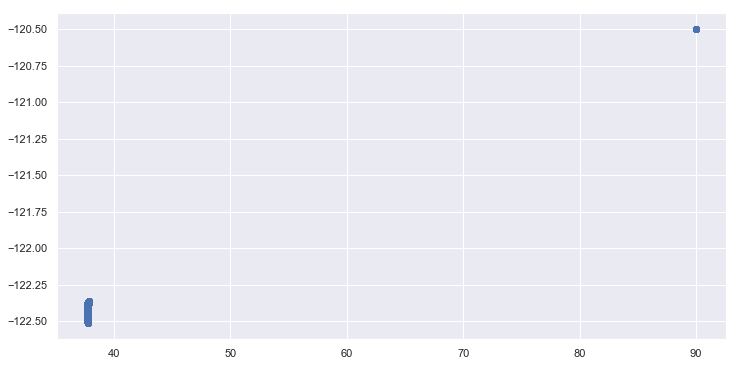

In [14]:
# Plot
plt.scatter(train_pd['Y'], train_pd['X'])
plt.show()

The latitude of San Francisco, CA, USA is 37.773972, and the longitude is -122.431297.
<br>Anything below lng -122.30 and  lat above 38 will be excluded from both train e test data set

In [15]:
print('Before the cleaning the shape was: '+str(train_pd.shape))
keep_train = train_pd[(train_pd['Y'] < 38) & (train_pd['X'] < -121.30)].index
train_pd = train_pd.iloc[keep_train].reset_index(drop=True)
print('After the cleaning the shape is: '+str(train_pd.shape))

print('Before the cleaning the shape was: '+str(test_pd.shape))
keep_test = test_pd[(train_pd['Y'] < 38) & (test_pd['X'] < -121.30)].index
test_pd = test_pd.iloc[keep_test].reset_index(drop=True)
print('After the cleaning the shape is: '+str(test_pd.shape))

Before the cleaning the shape was: (878049, 9)
After the cleaning the shape is: (877982, 9)
Before the cleaning the shape was: (884262, 7)
After the cleaning the shape is: (877906, 7)


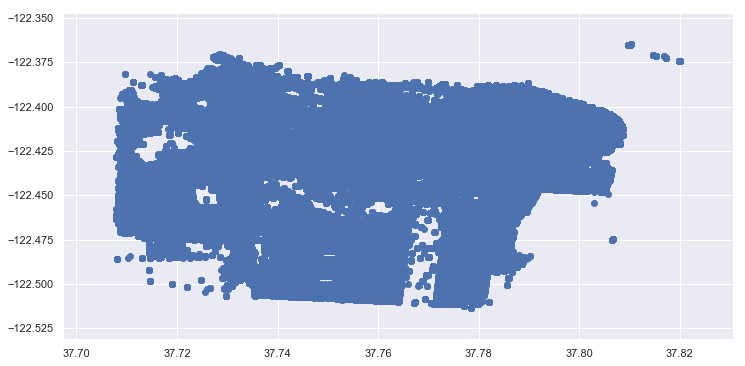

In [16]:
# Plot
plt.scatter(train_pd['Y'], train_pd['X'])
plt.show()

In [17]:
#rounding
train_pd['X']=train_pd['X'].round(10)
train_pd['Y']=train_pd['Y'].round(10)

test_pd['X']=test_pd['X'].round(10)
test_pd['Y']=test_pd['Y'].round(10)

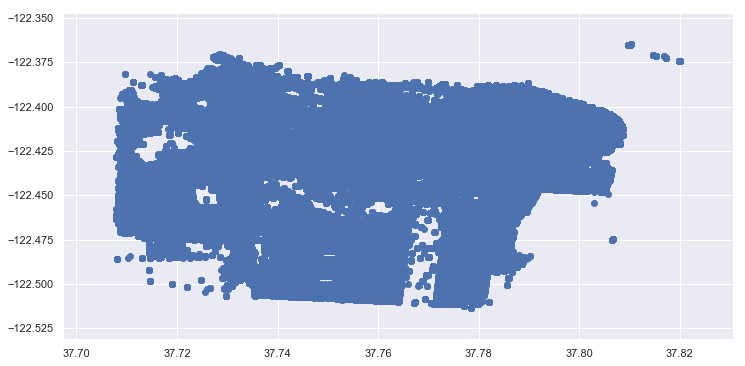

In [18]:
# Plot
plt.scatter(train_pd['Y'], train_pd['X'])
plt.show()

**DayOfWeek**

* categorical variable with 7 levels
* looks like number of reported crimes is highest on Friday for some reason
* highest vs lowest is about 12% decrease

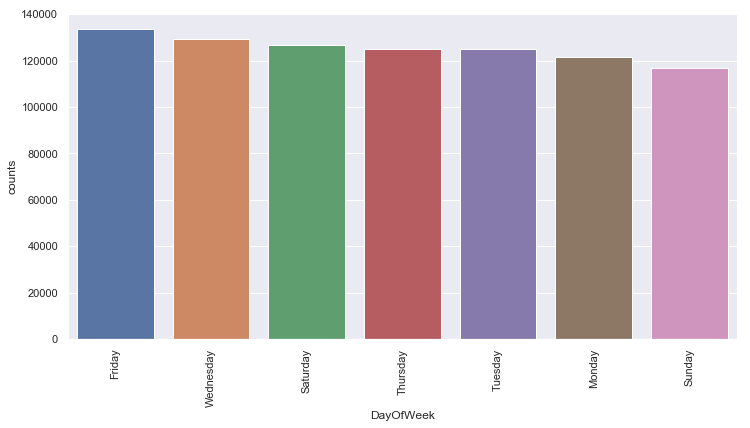

In [19]:
dat = train_pd.groupby(["DayOfWeek"]).size().reset_index(name='counts').sort_values(by = "counts", ascending = False)

sns.set(rc = {"figure.figsize" : (12, 6)})
ax = sns.barplot(x = "DayOfWeek", y = "counts", data=dat).\
    set_xticklabels(dat['DayOfWeek'], rotation = 90)


**Resolution**
* not available in Test data
* not very useful for prediction classification task

**Dates**
* transforming the dates
* droping the minutes
* creating one column with the hour of the day
* Transforming in numbers

In [20]:
#working on dates
#transforming the dates
train_pd['Dates'] = pd.to_datetime(train_pd['Dates'])
test_pd['Dates'] = pd.to_datetime(test_pd['Dates'])

#droping the minutes
train_pd['Dates']=train_pd['Dates'].dt.round('H')
test_pd['Dates']=test_pd['Dates'].dt.round('H')

#creating one column with the hour of the day
train_pd['hour']=train_pd['Dates'].dt.hour
test_pd['hour']=test_pd['Dates'].dt.hour


#transforming the dates to numbers
train_pd['Dates']=pd.to_numeric(train_pd['Dates'])
train_pd['Dates']=train_pd['Dates']/10000
train_pd['Dates']=train_pd['Dates'].round(0)
test_pd['Dates']=pd.to_numeric(test_pd['Dates'])
test_pd['Dates']=test_pd['Dates']/10000
test_pd['Dates']=test_pd['Dates'].round(0)

In [21]:
print('The total number of unique Dates is: ' + str(len(train_pd.Dates.unique())))

The total number of unique Dates is: 53899


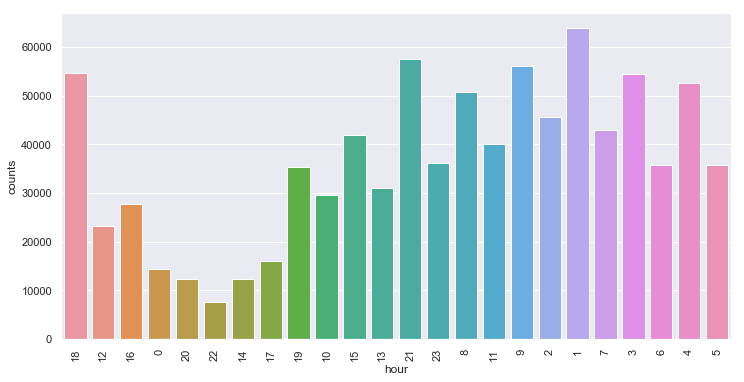

In [22]:
dat = train_pd.groupby(["hour"]).size().reset_index(name='counts').sort_values(by = "counts", ascending = False)

sns.set(rc = {"figure.figsize" : (12, 6)})
ax = sns.barplot(x = "hour", y = "counts", data=dat).\
    set_xticklabels(dat['hour'], rotation = 90)

In [23]:
#creating a variable for weekdays and weekend
train_pd['weekend'] = train_pd['DayOfWeek']
train_pd['weekend'] = train_pd['weekend'].replace('Sunday', 1)
train_pd['weekend'] = train_pd['weekend'].replace('Monday', 0)
train_pd['weekend'] = train_pd['weekend'].replace('Tuesday', 0)
train_pd['weekend'] = train_pd['weekend'].replace('Wednesday', 0)
train_pd['weekend'] = train_pd['weekend'].replace('Thursday', 0)
train_pd['weekend'] = train_pd['weekend'].replace('Friday', 0)
train_pd['weekend'] = train_pd['weekend'].replace('Saturday', 1)

test_pd['weekend'] = test_pd['DayOfWeek']
test_pd['weekend'] = test_pd['weekend'].replace('Sunday', 1)
test_pd['weekend'] = test_pd['weekend'].replace('Monday', 0)
test_pd['weekend'] = test_pd['weekend'].replace('Tuesday', 0)
test_pd['weekend'] = test_pd['weekend'].replace('Wednesday', 0)
test_pd['weekend'] = test_pd['weekend'].replace('Thursday', 0)
test_pd['weekend'] = test_pd['weekend'].replace('Friday', 0)
test_pd['weekend'] = test_pd['weekend'].replace('Saturday', 1)

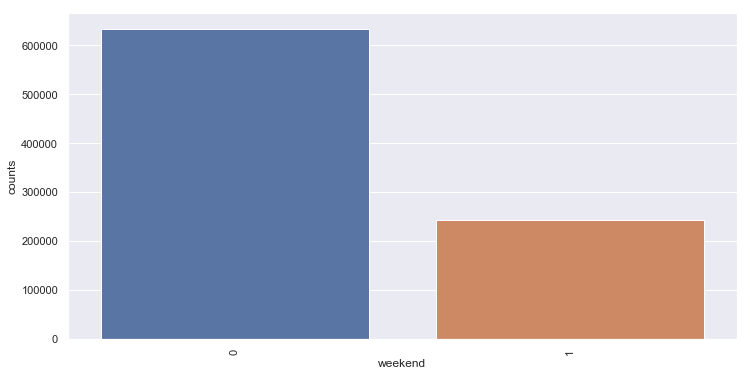

In [24]:
dat = train_pd.groupby(["weekend"]).size().reset_index(name='counts').sort_values(by = "counts", ascending = False)

sns.set(rc = {"figure.figsize" : (12, 6)})
ax = sns.barplot(x = "weekend", y = "counts", data=dat).\
    set_xticklabels(dat['weekend'], rotation = 90)


**Checking PCA to understand the explicability of the variables**
* this can help us understand which ones are worthy to keep

In [69]:
# extract some more features using our custom transformer
sfcc = SFCCTransformer()
pipe = Pipeline([
    ("transformer", sfcc)
])
train_pd = pipe.transform(train_pd)
test_pd = pipe.transform(test_pd)

In [70]:
len(test_pd)

884262

In [26]:
train_pd.head()

,Category,Descript,Resolution,X,Y,hour,weekend,pdd_BAYVIEW,pdd_CENTRAL,pdd_INGLESIDE,...,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,month_of_year_sin,month_of_year_cos,quarter_of_year_sin,quarter_of_year_cos
0,WARRANTS,WARRANT ARREST,"ARREST, BOOKED",0.590,0.595,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,"ARREST, BOOKED",0.590,0.595,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,"ARREST, BOOKED",0.600,0.825,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NONE,0.583,0.830,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,NONE,0.504,0.568,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
train_pd_s = train_pd[["X","Y","pdd_BAYVIEW","pdd_CENTRAL","pdd_INGLESIDE","pdd_MISSION",\
                     "pdd_NORTHERN","pdd_PARK","pdd_RICHMOND","pdd_SOUTHERN","pdd_TARAVAL","pdd_TENDERLOIN",\
                     "dow_Friday","dow_Monday","dow_Saturday","dow_Sunday","dow_Thursday","dow_Tuesday",\
                     "dow_Wednesday","hour_delta","day_delta","week_delta","month_delta","year_delta",\
                     "is_weekend","is_holiday","is_latenight","hod_4","hod_5","hod_6","hod_7","hod_8","hod_9",\
                     "hod_10","hod_11","hod_12","hod_13","hod_14","hod_15","dom_2","qoy_1",\
                     "hour_of_day_sin","hour_of_day_cos","day_of_week_sin","day_of_week_cos","day_of_month_sin",\
                     "day_of_month_cos","day_of_year_sin","day_of_year_cos","week_of_year_sin","week_of_year_cos",\
                     "month_of_year_sin","month_of_year_cos","quarter_of_year_sin","quarter_of_year_cos"]].copy()
train_pd_s.head()

,X,Y,pdd_BAYVIEW,pdd_CENTRAL,pdd_INGLESIDE,pdd_MISSION,pdd_NORTHERN,pdd_PARK,pdd_RICHMOND,pdd_SOUTHERN,...,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,month_of_year_sin,month_of_year_cos,quarter_of_year_sin,quarter_of_year_cos
0,0.590,0.595,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.590,0.595,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.600,0.825,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.583,0.830,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.504,0.568,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


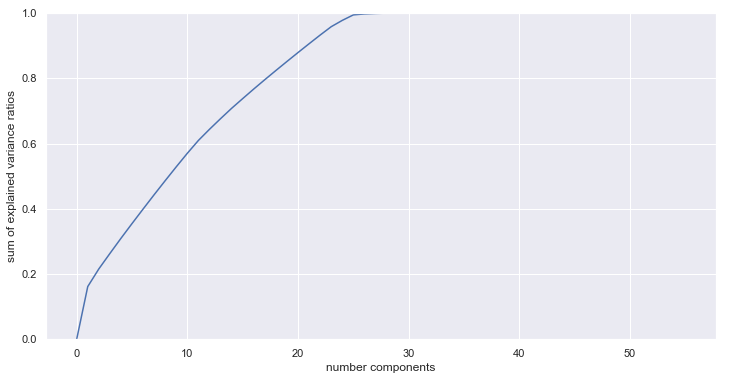

Number of component is 1 the explainability is 0.0
Number of component is 2 the explainability is 0.1615361538724169
Number of component is 3 the explainability is 0.2155966441487977
Number of component is 4 the explainability is 0.2629167707462275
Number of component is 5 the explainability is 0.3094654576530112
Number of component is 6 the explainability is 0.35470241906025324
Number of component is 7 the explainability is 0.399198159448366
Number of component is 8 the explainability is 0.4432124065713349
Number of component is 9 the explainability is 0.4863471853579378
Number of component is 10 the explainability is 0.5288076429296884
Number of component is 11 the explainability is 0.5702817568808435
Number of component is 12 the explainability is 0.6096123699597872
Number of component is 13 the explainability is 0.6437240774189227
Number of component is 14 the explainability is 0.6763507154799504
Number of component is 15 the explainability is 0.7080543169047714
Number of component

In [28]:
#setting the number of componentes
n_comp = len(train_pd_s.columns)

# perform PCA
pca_mod = PCA(n_components = n_comp)
pca_mod.fit(train_pd_s)

evr = pca_mod.explained_variance_ratio_
s_evr = np.cumsum(np.concatenate(([0], evr)))

#ploting the first components to the total variance that can be explained by those
plt.plot(range(n_comp+1),s_evr)
plt.xlabel('number components')
plt.ylabel('sum of explained variance ratios')
plt.ylim([0,1])
plt.show()

for cis in range(len(s_evr)):
    print('Number of component is '+ str(cis + 1) + ' the explainability is ' + str(s_evr[cis]))

In [29]:
#as it can be seen above, the optimal number of parameters varies from 10 to 21. 
#we will create one pca_mods, with 33 variables
n_comp = 10
pca_10 = PCA(n_components = n_comp)
pca_dat_10 = pca_10.fit_transform(train_pd_s)

n_comp = 21
pca_33 = PCA(n_components = n_comp)
pca_dat_33 = pca_33.fit_transform(train_pd_s)

**Shuffle the data**
* Shuffle the data to avoid issues with it

In [30]:
train_pd = train_pd.sample(frac=1).reset_index(drop=True)

# Classification

In [ ]:
# TODO add feature selection

In [31]:
train_data = train_pd.copy()
print(train_data.shape)

# gets the train labels
train_labels = train_data["Category"]

print(train_labels.shape)

(877982, 62)
(877982,)


**Running choosing the best by hand**

* KNN

In [32]:
# pipeline to prep our data and fit classifiers
selector = DataFrameSelector(["X", "Y","day_of_month_sin","day_of_month_cos"\
                             ,"day_of_year_sin","day_of_year_cos","week_of_year_sin","week_of_year_cos"])
n_nei = [3, 5, 10, 15, 20, 25, 30, 40, 50, 100]
knn_manual_cv = []
knn_manual_time = []

for jkl  in n_nei:
    begin = datetime.datetime.now()
    knn = KNeighborsClassifier(n_neighbors=jkl)

    pipe = Pipeline([
        ("selector", selector)
        ,("knn", knn)
    ])

    param_grid = {
        "selector__attribute_names": [
            ["X", "Y"]
            ,["X", "Y","is_latenight"]
        ],
        "knn__n_neighbors": [jkl]
    }

    search = GridSearchCV(pipe, param_grid,scoring='neg_log_loss' ,iid = True, cv = 3, return_train_score = False)

    _ = search.fit(train_data, train_labels)
    print("n_neighbors %3.0f Best parameter (CV score=%0.3f):" % (jkl,search.best_score_))
    print(search.best_params_)
    end = datetime.datetime.now()
    knn_manual_cv.append(search.best_score_)
    knn_manual_time.append(end-begin)

n_neighbors   3 Best parameter (CV score=-21.556):
{'knn__n_neighbors': 3, 'selector__attribute_names': ['X', 'Y', 'is_latenight']}
n_neighbors   5 Best parameter (CV score=-17.795):
{'knn__n_neighbors': 5, 'selector__attribute_names': ['X', 'Y', 'is_latenight']}
n_neighbors  10 Best parameter (CV score=-12.706):
{'knn__n_neighbors': 10, 'selector__attribute_names': ['X', 'Y', 'is_latenight']}
n_neighbors  15 Best parameter (CV score=-10.149):
{'knn__n_neighbors': 15, 'selector__attribute_names': ['X', 'Y', 'is_latenight']}
n_neighbors  20 Best parameter (CV score=-8.619):
{'knn__n_neighbors': 20, 'selector__attribute_names': ['X', 'Y', 'is_latenight']}
n_neighbors  25 Best parameter (CV score=-7.527):
{'knn__n_neighbors': 25, 'selector__attribute_names': ['X', 'Y', 'is_latenight']}
n_neighbors  30 Best parameter (CV score=-6.761):
{'knn__n_neighbors': 30, 'selector__attribute_names': ['X', 'Y', 'is_latenight']}
n_neighbors  40 Best parameter (CV score=-5.725):
{'knn__n_neighbors': 40,

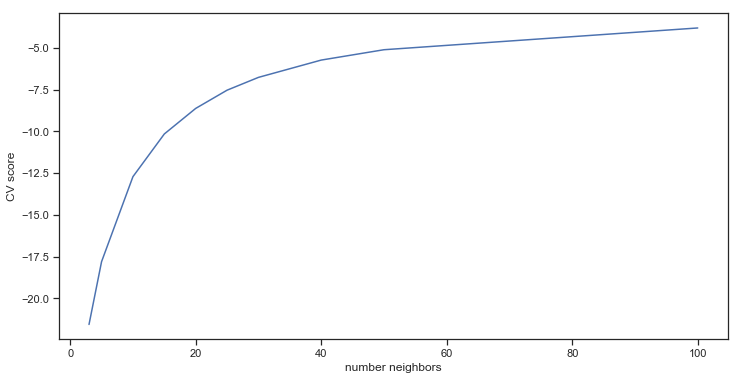

In [76]:
#ploting knn performance
plt.plot(n_nei,knn_manual_cv)
plt.xlabel('number neighbors')
plt.ylabel('CV score')
plt.show()


In [81]:
for g in range(0,len(knn_manual_time)):
    knn_manual_time[g]=knn_manual_time[g].total_seconds()

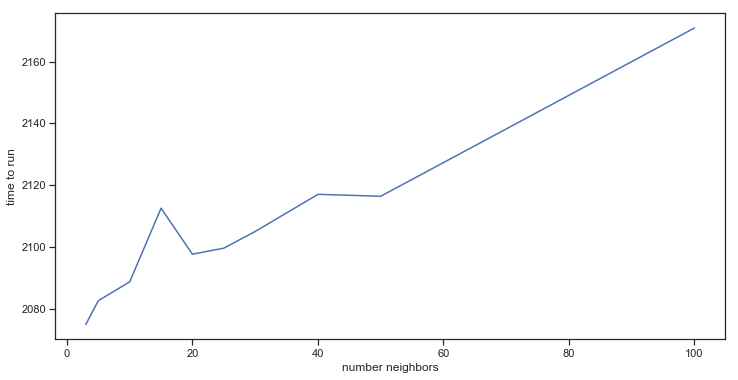

In [85]:
#ploting knn time
plt.plot(n_nei,knn_manual_time)
plt.xlabel('number neighbors')
plt.ylabel('time to run')
plt.show()

* Logistic Regression

In [36]:
# pipeline to prep our data and fit classifiers
selector = DataFrameSelector(["X", "Y","day_of_month_sin","day_of_month_cos"\
                             ,"day_of_year_sin","day_of_year_cos","week_of_year_sin","week_of_year_cos"])

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

log_manual_cv = []
log_manual_time = []


for cs in C:
    begin = datetime.datetime.now() 
    log = LogisticRegression(C=cs)
    pipe = Pipeline([
        ("selector", selector)
        ,("log", log)
    ])

    param_grid = {
        "selector__attribute_names": [
            ["X", "Y"]
            ,["X", "Y","is_latenight"]
        ]
    }

    search = GridSearchCV(pipe, param_grid,scoring='neg_log_loss' ,iid = True, cv = 3, return_train_score = False)

    _ = search.fit(train_data, train_labels)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    end = datetime.datetime.now()
    log_manual_cv.append(search.best_score_)
    log_manual_time.append(end-begin)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

Best parameter (CV score=-2.643):
{'selector__attribute_names': ['X', 'Y', 'is_latenight']}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

Best parameter (CV score=-2.643):
{'selector__attribute_names': ['X', 'Y', 'is_latenight']}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

Best parameter (CV score=-2.643):
{'selector__attribute_names': ['X', 'Y', 'is_latenight']}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

Best parameter (CV score=-2.643):
{'selector__attribute_names': ['X', 'Y', 'is_latenight']}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

Best parameter (CV score=-2.643):
{'selector__attribute_names': ['X', 'Y', 'is_latenight']}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

Best parameter (CV score=-2.643):
{'selector__attribute_names': ['X', 'Y', 'is_latenight']}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

Best parameter (CV score=-2.643):
{'selector__attribute_names': ['X', 'Y', 'is_latenight']}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

Best parameter (CV score=-2.643):
{'selector__attribute_names': ['X', 'Y', 'is_latenight']}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

Best parameter (CV score=-2.643):
{'selector__attribute_names': ['X', 'Y', 'is_latenight']}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

Best parameter (CV score=-2.643):
{'selector__attribute_names': ['X', 'Y', 'is_latenight']}


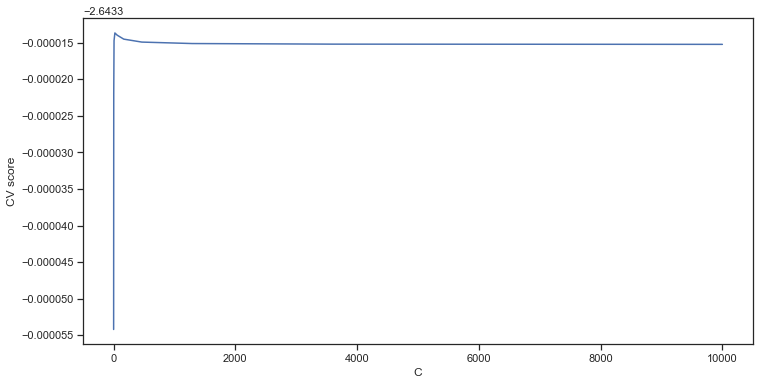

In [88]:
#ploting log performance
plt.plot(np.logspace(0, 4, 10),log_manual_cv)
plt.xlabel('C')
plt.ylabel('CV score')
plt.show()


In [90]:
for g in range(0,len(log_manual_time)):
    log_manual_time[g]=log_manual_time[g].total_seconds()

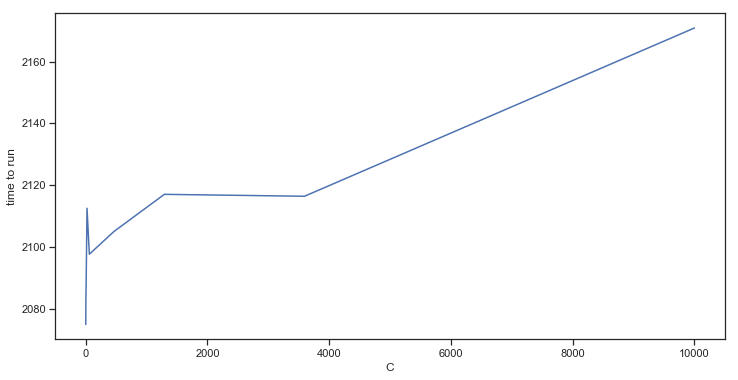

In [91]:
#ploting log time
plt.plot(C,log_manual_time)
plt.xlabel('C')
plt.ylabel('time to run')
plt.show()

* Random Forest

In [34]:
# pipeline to prep our data and fit classifiers
selector = DataFrameSelector(["X", "Y","day_of_month_sin","day_of_month_cos"\
                             ,"day_of_year_sin","day_of_year_cos","week_of_year_sin","week_of_year_cos"])
n_estimators = [16, 32, 64, 100, 200, 300, 500, 600]

random_manual_cv = []
random_manual_time = []

for estimator in n_estimators:
    begin = datetime.datetime.now() 
    random_forest = RandomForestClassifier(n_estimators=estimator)

    pipe = Pipeline([
        ("selector", selector),
        ("random_forest", random_forest)
    ])

    param_grid = {
        "selector__attribute_names": [
            ["X", "Y"]
            ,["X", "Y","is_latenight"]
        ]
    }

    search = GridSearchCV(pipe,param_grid,scoring='neg_log_loss' ,iid = True, cv = 3, return_train_score = False)

    _ = search.fit(train_data, train_labels)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    end = datetime.datetime.now()
    random_manual_cv.append(search.best_score_)
    random_manual_time.append(end-begin)

Best parameter (CV score=-8.317):
{'selector__attribute_names': ['X', 'Y']}
Best parameter (CV score=-7.099):
{'selector__attribute_names': ['X', 'Y']}
Best parameter (CV score=-6.585):
{'selector__attribute_names': ['X', 'Y']}
Best parameter (CV score=-6.427):
{'selector__attribute_names': ['X', 'Y']}
Best parameter (CV score=-6.314):
{'selector__attribute_names': ['X', 'Y']}
Best parameter (CV score=-6.200):
{'selector__attribute_names': ['X', 'Y']}
Best parameter (CV score=-6.083):
{'selector__attribute_names': ['X', 'Y']}
Best parameter (CV score=-5.994):
{'selector__attribute_names': ['X', 'Y']}


In [97]:
ks = [1, 2, 4, 8, 16, 32, 64, 100]

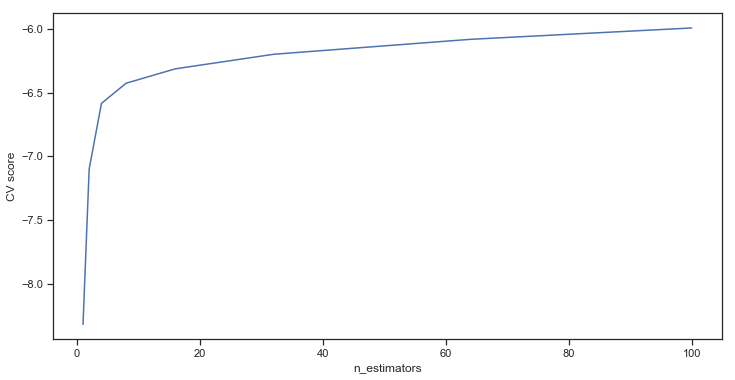

In [98]:
#ploting random performance
plt.plot(ks,random_manual_cv)
plt.xlabel('n_estimators')
plt.ylabel('CV score')
plt.show()



In [100]:
for g in range(0,len(random_manual_time)):
    random_manual_time[g]=random_manual_time[g].total_seconds()

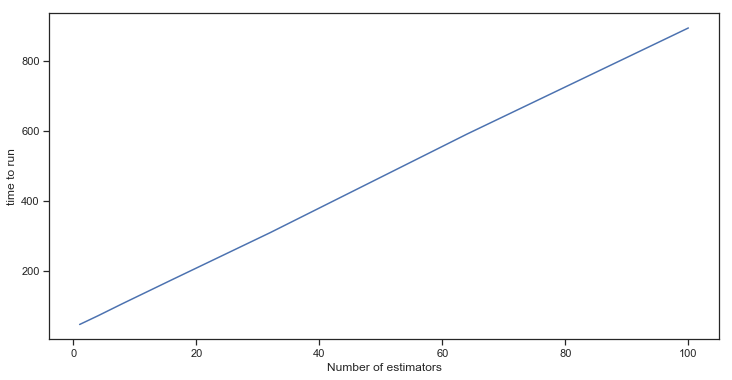

In [101]:
#ploting random time
plt.plot(ks,random_manual_time)
plt.xlabel('Number of estimators')
plt.ylabel('time to run')
plt.show()

* Gradient Boosted Three

In [35]:
# pipeline to prep our data and fit classifiers
selector = DataFrameSelector(["X", "Y","day_of_month_sin","day_of_month_cos"\
                             ,"day_of_year_sin","day_of_year_cos","week_of_year_sin","week_of_year_cos"])

learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]

gbt_manual_cv = []
gbt_manual_time = []

for eta in learning_rates:
    begin = datetime.datetime.now() 
    xboosted = GradientBoostingClassifier(learning_rate=eta)

    pipe = Pipeline([
        ("selector", selector)
        ,("X_Boosted", xboosted)
    ])

    param_grid = {
        "selector__attribute_names": [
            ["X", "Y"]
            ,["X", "Y","is_latenight"]
        ]
    }

    search = GridSearchCV(pipe,param_grid,scoring='neg_log_loss' ,iid = True, cv = 3, return_train_score = False)

    _ = search.fit(train_data, train_labels)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    end = datetime.datetime.now()
    gbt_manual_cv.append(search.best_score_)
    gbt_manual_time.append(end-begin)

KeyboardInterrupt: 

# Running with PCA numbers

* Logistics Regression

In [105]:
from sklearn.model_selection import cross_val_score

log_pca_cv = []
log_pca_time = []

test_pca = [10,15,20,25,30]

for ihg in test_pca:
    begin = datetime.datetime.now() 
    n_comp = ihg
    pca_10 = PCA(n_components = n_comp)
    pca_dat_10 = pca_10.fit_transform(train_pd_s)
    
    X, y = pca_dat_10, train_labels
    clf = LogisticRegression()
    clf.fit(X, y)
    
    score = cross_val_score(clf, X, y, scoring='neg_log_loss',cv=5)[0]
    end = datetime.datetime.now()
    log_pca_cv.append(score)
    log_pca_time.append(end-begin)
    print(score)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed

-2.6851439357581146


In [ ]:
pca_10 = PCA(n_components = 18)
pca_dat_10 = pca_10.fit_transform(train_pd_s)

grid_values = {'penalty': ['l1','l2'], 'C': [0.01,0.1,10]}

log = LogisticRegression()
model_lr = GridSearchCV(log, param_grid=grid_values,scoring='neg_log_loss')

_ = model_lr.fit(pca_dat_10, train_labels)
print("Best parameter (CV score=%0.3f):" % model_lr.best_score_)
print(model_lr.best_params_)
end = datetime.datetime.now()
log_manual_cv.append(model_lr.best_score_)
log_manual_time.append(end-begin)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWar

In [ ]:
pca_test_pd = pca_10.fit_transform(test_pd)
# makes predictions against our test data using our best classifier
predsproba = model_lr.predict_proba(pca_test_pd)

# predsproba = search.best_estimator_.predict_proba(pca_test_pd)
# print(predsproba[0:3])
len(predsproba)

In [ ]:
# converts predicted probabilities into submission panda
submissions = prep_submissions(predsproba, train_pd.Category)

print(submissions.shape)
print(submissions.head(3))

# checks submission has the correct number of rows and columns
assert(sample_submissions.shape[0] == submissions.shape[0])
assert(sample_submissions.shape[1] == submissions.shape[1])

In [ ]:
# save submissions to disk
submissions.to_csv("../data/processed/submission_log_pca.csv.gz", index = False, compression = "gzip")

* KNN

In [ ]:
KNN_pca_cv = []
KNN_pca_time = []

test_pca = [10,15,20,25,30]

for ihg in test_pca:
    begin = datetime.datetime.now() 
    n_comp = ihg
    pca_10 = PCA(n_components = n_comp)
    pca_dat_10 = pca_10.fit_transform(train_pd_s)
    
    X, y = pca_dat_10, train_labels
    knn = KNeighborsClassifier()
    
    grid_values={'n_neighbors': array([10,20,50,80,90,100])}
    model_knn = GridSearchCV(knn, param_grid=grid_values,scoring='neg_log_loss')

    _ = model_knn.fit(pca_dat_10, train_labels)
    print("Best parameter (CV score=%0.3f):" % model_knn.best_score_)
    print(model_knn.best_params_)
    end = datetime.datetime.now()
    KNN_pca_cv.append(model_knn.best_score_)
    KNN_pca_time.append(end-begin)

In [ ]:
KNN_pca_cv = []
KNN_pca_time = []

begin = datetime.datetime.now() 
n_comp = 18
pca_10 = PCA(n_components = n_comp)
pca_dat_10 = pca_10.fit_transform(train_pd_s)

X, y = pca_dat_10, train_labels
knn = KNeighborsClassifier()

grid_values={'n_neighbors': array([10,50,100])}
model_knn = GridSearchCV(knn, param_grid=grid_values,scoring='neg_log_loss')

_ = model_knn.fit(pca_dat_10, train_labels)
print("Best parameter (CV score=%0.3f):" % model_knn.best_score_)
print(model_knn.best_params_)
end = datetime.datetime.now()
KNN_pca_cv.append(model_knn.best_score_)
KNN_pca_time.append(end-begin)

In [ ]:
pca_test_pd = pca_10.fit_transform(test_pd)
# makes predictions against our test data using our best classifier
predsproba = model_knn.predict_proba(pca_test_pd)

# predsproba = search.best_estimator_.predict_proba(pca_test_pd)
# print(predsproba[0:3])
len(predsproba)

In [ ]:
# converts predicted probabilities into submission panda
submissions = prep_submissions(predsproba, train_pd.Category)

print(submissions.shape)
print(submissions.head(3))

# checks submission has the correct number of rows and columns
assert(sample_submissions.shape[0] == submissions.shape[0])
assert(sample_submissions.shape[1] == submissions.shape[1])

In [ ]:
# save submissions to disk
submissions.to_csv("../data/processed/submission_knn_pca.csv.gz", index = False, compression = "gzip")

* Random Forest

In [ ]:
rando_pca_cv = []
rando_pca_time = []

begin = datetime.datetime.now() 
n_comp = 18
pca_10 = PCA(n_components = n_comp)
pca_dat_10 = pca_10.fit_transform(train_pd_s)

X, y = pca_dat_10, train_labels
rando = RandomForestClassifier()

grid_values = { 
            "n_estimators"      : [100,300,500],
            "max_features"      : ["auto", "log2"],
            "min_samples_split" : [2,8],
            "bootstrap": [True, False],
            }

model_rando = GridSearchCV(rando, param_grid=grid_values,scoring='neg_log_loss')

_ = model_rando.fit(pca_dat_10, train_labels)
print("Best parameter (CV score=%0.3f):" % model_rando.best_score_)
print(model_rando.best_params_)
end = datetime.datetime.now()
rando_pca_cv.append(model_rando.best_score_)
rando_pca_time.append(end-begin)

In [ ]:
pca_test_pd = pca_10.fit_transform(test_pd)
# makes predictions against our test data using our best classifier
predsproba = model_rando.predict_proba(pca_test_pd)

# predsproba = search.best_estimator_.predict_proba(pca_test_pd)
# print(predsproba[0:3])
len(predsproba)

In [ ]:
# converts predicted probabilities into submission panda
submissions = prep_submissions(predsproba, train_pd.Category)

print(submissions.shape)
print(submissions.head(3))

# checks submission has the correct number of rows and columns
assert(sample_submissions.shape[0] == submissions.shape[0])
assert(sample_submissions.shape[1] == submissions.shape[1])

In [ ]:
# save submissions to disk
submissions.to_csv("../data/processed/submission_random_pca.csv.gz", index = False, compression = "gzip")

* Gradient Boosted Three

In [ ]:
xboost_pca_cv = []
xboost_pca_time = []

begin = datetime.datetime.now() 
n_comp = 18
pca_10 = PCA(n_components = n_comp)
pca_dat_10 = pca_10.fit_transform(train_pd_s)

X, y = pca_dat_10, train_labels
xboost = GradientBoostingClassifier()

grid_values = { 
            "n_estimators"      : [100,300,500],
            "max_features"      : ["auto", "log2"],
            "min_samples_split" : [2,8],
            "bootstrap": [True, False],
            }

model_xboost = GridSearchCV(xboost, param_grid=grid_values,scoring='neg_log_loss')

_ = model_xboost.fit(pca_dat_10, train_labels)
print("Best parameter (CV score=%0.3f):" % model_xboost.best_score_)
print(model_xboost.best_params_)
end = datetime.datetime.now()
xboost_pca_cv.append(model_xboost.best_score_)
xboost_pca_time.append(end-begin)

In [ ]:
pca_test_pd = pca_10.fit_transform(test_pd)
# makes predictions against our test data using our best classifier
predsproba = model_xboost.predict_proba(pca_test_pd)

# predsproba = search.best_estimator_.predict_proba(pca_test_pd)
# print(predsproba[0:3])
len(predsproba)

In [ ]:
# converts predicted probabilities into submission panda
submissions = prep_submissions(predsproba, train_pd.Category)

print(submissions.shape)
print(submissions.head(3))

# checks submission has the correct number of rows and columns
assert(sample_submissions.shape[0] == submissions.shape[0])
assert(sample_submissions.shape[1] == submissions.shape[1])

In [ ]:
# save submissions to disk
submissions.to_csv("../data/processed/submission_xboost_pca.csv.gz", index = False, compression = "gzip")

# Appendicies

## DataFrameSelector

In [ ]:
lines = inspect.getsource(DataFrameSelector)
print(lines)

## SFCCTransformer

In [ ]:
lines = inspect.getsource(SFCCTransformer)
print(lines)

## prep_submissions

In [ ]:
lines = inspect.getsource(prep_submissions)
print(lines)